# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib

import import_ipynb

# Import data

In [3]:
import data_preprocessing

# load the data as formatted dataframe
data = data_preprocessing.Data(tags_or_genres='genres', min_label_occ=50)
print(data.games.head())

   game_id                                               name  \
0  1418860  Zaccaria Pinball - House of Diamonds Deluxe Pi...   
1  1418900                Sayonara Golden Days - Golden Souls   
2  1418980          Medieval Dynasty - Digital Supporter Pack   
3  1418990                              Unicorns on Unicycles   
4  1419040                         Road Maintenance Simulator   

                                         description  \
0  purchase this dlc disables score limit on this...   
1  the dlc will does not affect really affect the...   
2  the digital supporter pack of medieval dynasty...   
3  turn your horns into swords in this wacky and ...   
4  experience the everyday life in a german stree...   

                                              genres  
0  [Action,  Casual,  Free to Play,  Indie,  Simu...  
1                                            [Indie]  
2            [Action,  Adventure,  RPG,  Simulation]  
3                          [Action,  Casual,  Indie]

In [4]:
data.games['description'].shape

(138911,)

# Input preprocessing
Convert complex input (game description) into simple input for model  
Result input variable will be named `X`

We will be using [Sklearn library](https://scikit-learn.org/1.5/modules/feature_extraction.html) to perform the feature extraction

In [5]:
import input_preprocessing

X = input_preprocessing.bag_of_words(data.games['description'], max_features=10000)
# X = input_preprocessing.tfidf(data.games['description'], max_features=10000)
# X = input_preprocessing.hashing(data.games['description'], n_features=100)
X.shape

(138911, 10000)

# Output preprocessing
Convert complex output (game tags) into simple output for model (multi-label classification)  
Resulting output variable will be named `y`

In [6]:
import output_preprocessing

y = output_preprocessing.multilabel_binarizer(data.games['genres'])
y.shape

(138911, 52)

# Evaluation methods
We want to create function `evaluate(y_pred, y_true)` that will evaluate the model performance

In [7]:
import evaluation_methods

# evaluate = evaluation_methods.recall
# evaluate = evaluation_methods.jaccardscore
# evaluate = evaluation_methods.exactmatch
# evaluate = evaluation_methods.hammingloss
evaluate = evaluation_methods.f1score

# Model
Use the given preprocessed input `X`, output `y`, evaluation functions `evaluate(y_pred, y_true)`, to train a chosen model (and save the model)  
Resulting model will be class named `Model` with methods:  
* fit(X, y) - train the model
* predict(X) - predict the output for given input
* save_model(path) - save the model to the given path
* load_model(path) - load the model from the given path
* evaluate() - evaluate the model performance

In [8]:
import models

# model = models.KNN(X, y, evaluate)
# model = models.LogisticRegression(X, y, evaluate)
# model = models.DecisionTree(X, y, evaluate)
# model = models.RandomForest(X, y, evaluate)
# model = models.NaiveBayes(X, y, evaluate)
model = models.SVM(X, y, evaluate)
# model = models.MLP(X, y, evaluate)

# Model training and evaluation

In [9]:
model.fit()
print(model.evaluate())

KeyboardInterrupt: 

# Data visualization
Play with the data, visualize model performance, etc.

## Model

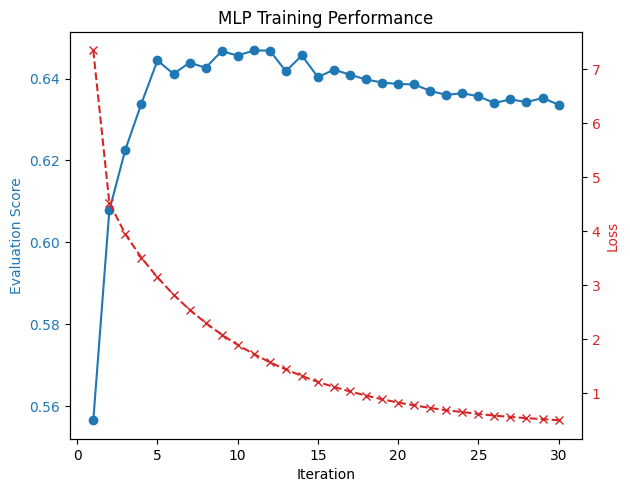

In [13]:
def plot_performance():
    plt.plot(model.history_, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Evaluation Score")
    plt.title("Model Performance Over Iterations")
    plt.show()

def plot_performance_decision_trees():
    depths = [record['max_depth'] for record in model.history_]
    scores = [record['score'] for record in model.history_]

    plt.plot(depths, scores, marker='o')
    plt.xlabel('Tree Depth')
    plt.ylabel('Evaluation Score')
    plt.title('Decision Tree Performance by Depth')
    plt.show()

def plot_performance_nb():
    alphas = [record['alpha'] for record in model.history_]
    scores = [record['score'] for record in model.history_]

    plt.plot(alphas, scores, marker='o')
    plt.xlabel('Alpha Value')
    plt.ylabel('Evaluation Score')
    plt.title('Naive Bayes Performance by Alpha')
    plt.show()

def plot_performance_svm():
    C_values = [record['C'] for record in model.history_]
    scores = [record['score'] for record in model.history_]

    plt.plot(C_values, scores, marker='o')
    plt.xscale('log')  
    plt.xlabel('C Value')
    plt.ylabel('Evaluation Score')
    plt.title('SVM Performance by C Value')
    plt.show()

def plot_performance_mlp():
    iterations = [record['iteration'] for record in model.history_]
    scores = [record['score'] for record in model.history_]
    losses = [record['loss'] for record in model.history_]

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Evaluation Score', color='tab:blue')
    ax1.plot(iterations, scores, marker='o', color='tab:blue', label='Score')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(iterations, losses, marker='x', color='tab:red', linestyle='--', label='Loss')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('MLP Training Performance')
    plt.show()
    
def plot_mlp_over_methods():
	evaluate = {
		'recall': evaluation_methods.recall,
		'f1': evaluation_methods.f1score,
		'hamming': evaluation_methods.hamming_loss,
		'exact_match': evaluation_methods.exactmatch,
		#   'jaccard': evaluation_methods.jaccard_score,
	}
	scores = []
	for name, eval_method in evaluate.items():
		print(f"Training MLP with {name} evaluation method")
		model = models.MLP(X, y, eval_method)
		model.fit()
		scores.append(model.evaluate())
	plt.bar(list(evaluate.keys()), scores)
	plt.xlabel('Evaluation method')
	plt.ylabel('Score')
	plt.title('Scores over different evaluation methods')
	plt.show()
	


# plot_performance()
# plot_performance_decision_trees()
# plot_performance_nb()
# plot_performance_mlp()
# plot_performance_svm()
plot_mlp_over_methods()